In [4]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

from tqdm import tqdm_notebook as tqdm

import rpy2.robjects as robjects

from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import gaussian_kde

import pickle

In [5]:
def generate_S_indices(dist_matrix, alpha, n_inds=1, return_new_dists=False, beta=0.5):
    """
    A function to generate the nodes of interest.
    
    Input
    dist_matrix - np.array (shape=(n,J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    alpha - float or array-like
        Coefficients of the distances to generate the ground truth. alpha can only be an int
        if J == 2. If alpha is array-like then the sum of alpha must be 1.
    n_inds - int or func
        Number of vertices in the vertex set of interest. If n_inds is a function then the
        ceiling of n_inds(n) is used.
        
    Return
    S - np.array (length=n_inds)
        A list of indices of length n_inds in range(1,n) corresponding to vertices of interest.
    """
    
    n, J = dist_matrix.shape
    
    if isinstance(alpha, float):
        if J == 2:
            alpha = [alpha, 1-alpha]
        elif J == 4:
            alpha = np.array([beta*alpha, beta*(1-alpha), (1-beta)*alpha, (1-beta)*(1-alpha)])
    
    assert np.sum(alpha) == 1
    
    if not isinstance(n_inds, int):
        n_inds = int(np.math.ceil(n_inds(n)))
    
    new_distances = np.average(dist_matrix, axis=1, weights=alpha)
    
    new_nearest_neighbors = np.argsort(new_distances)
    
    S = new_nearest_neighbors[1:n_inds+1]
    
    if return_new_dists:
        return S, new_distances
    else:
        return S


def optimal_distance(dist_matrix, S_indices, model_name=None, return_new_dists=True):
    """
    A function to find the weights of optimal linear combination of distances.
    
    Input
    dist_matrix - np.array (shape=(n, J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    S_indices - array-like
        Array-like containing the indices of the vertices that should be at the top of the
        nomination list for the vertex of interest.
        
    Return
    weights - np.array (length=J)
        Array containing the coefficients for the optimal distance function.
    """
    
    n, J = dist_matrix.shape
    M = np.sum(abs(dist_matrix))
    
    S = len(S_indices)
    Q_indices = np.array([i for i in range(1, n) if i not in S_indices])
    Q = len(Q_indices)
    
    M = np.sum(abs(dist_matrix))
    
    if model_name is not None:
        m = gp.Model(name='%s'%(model_name))
    else:
        m= gp.Model()
        
    m.setParam('OutputFlag', 0)

    ind = m.addVars(Q, vtype=GRB.BINARY, name='ind')
    m.setObjective(gp.quicksum(ind), GRB.MINIMIZE)

    w = m.addVars(J, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='w')
    m.addConstr(w.sum() == 1)

    # There's likely a more pythonic way to set up these constraints (in particular using m.addConstrs(..))
    for s in S_indices:
        temp_s = gp.tupledict([((i), dist_matrix[s, i]) for i in range(J)])
        for i, q in enumerate(Q_indices):
            temp_q = gp.tupledict([((i), dist_matrix[q, i]) for i in range(J)])
            m.addConstr(w.prod(temp_s) <= w.prod(temp_q) + ind[i]*M)
        
    m.optimize()
    
    alpha_hat = np.array([i.X for i in list(w.values())])
    
    if model_name:
        m.write('%s.ip'%(model_name))
        
    if return_new_dists:
        return alpha_hat, np.average(dist_matrix, axis=1, weights=alpha_hat)
    
    return alpha_hat


def rank_distance(true_ranks, estimated_ranks):
    return np.mean(abs(true_ranks - estimated_ranks))


def mean_reciprocal_rank(rank_list, inds):
    """
    Calculates mean reciprocal rank given a rank list and set of indices of interest.
    
    Input
    rank_list - array-like (length=n-1)
        A ranked array-like of objects (assumed to be integers).
    inds - array-like (length<=n-1)
        A array-like of objects (assumed to be integers).
        
    Return
    mrr - float
        Mean reciprocal rank of the objects in inds.
    """
        
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
    return np.mean(1/ranks)

def mean_rank(rank_list, inds):
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
#     print(ranks)
    return np.mean(ranks)


def remove_S_indices(rank_lists, S_indices):
    new_rank_lists = []
    for i, r in enumerate(rank_lists):
        idx = np.array([np.where(r == s)[0][0] for s in S_indices])
        new_rank_lists.append(np.delete(r, idx))
        
    return new_rank_lists


def average_rank(rank_lists, s_star_indices):
    
    average_ranks = np.zeros(len(rank_lists))
    
    for i, r in enumerate(rank_lists):
        average_ranks[i] = np.mean(np.array([np.where(r == s)[0][0] for s in s_star_indices]))
    
    return average_ranks

def plot_kde_differences(all_data, figsize=(8,6), h=1, num=1000, chance=None, suptitle=None, filename=None):
    J, n = all_data.shape
    colors = sns.color_palette('Set1', n_colors=J)
    
    min_ = min(np.array([min(data) for data in all_data]))
    max_ = max(np.array([max(data) for data in all_data]))
    
    linspace = np.linspace(min_ - h, max_ + h, num)
    
    fig, ax = plt.subplots(J, J, sharex=True, sharey=True)
    
#     ax[0,0].set_ylim(-0.2, 0.2)
    
    for i, di in enumerate(all_data):
        for j, dj in enumerate(all_data):
            if i == j:
                temp_kdei = gaussian_kde(di)
                ax[i,i].plot(linspace, temp_kdei.pdf(linspace), c=colors[-i-1])
#                 sns.kdeplot(di, ax=ax[i,j], c=c[i])
                if chance:
                    ax[i,i].axvline(x=chance, c='k', ls='--', lw=1)
            else:
                temp_kdei = gaussian_kde(di)
                temp_kdej = gaussian_kde(dj)
                
                ax[i,j].plot(linspace, temp_kdei.pdf(linspace) - temp_kdej.pdf(linspace), ls="--")
            ax[i,j].axhline(y=0, c='k', lw=1)
            
            
    if suptitle is not None:
        fig.suptitle(suptitle)
        
    if filename:
        plt.savefig(filename)
        
def estimate_chance_mrr(n, nZ, nmc=10000):
    mrrs = np.zeros(nmc)
    
    for i in range(nmc):
        temp = np.random.choice(n, nZ, replace=False) + 1
        mrrs[i] = np.mean(1 / temp)
        
    return np.mean(mrrs)

In [6]:
def mean_reciprocal_rank(rank_list, inds):
    """
    A function to compute the mean reciprocal rank of a set of indices.
    
    Input
    rank_list - array of ints
        Array containing the ranked objects indices. rank_list[i] is original index the ith ranked object. 
    inds - array-like of ints
        Indices of objects for which you want their ranking, per rank_list.
        
    Return
    The mean reciprocal rank of the objects in inds.
    """
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
    
    return np.mean(1 / ranks)

def find_best_vertices(dist_matrix, S_indices):
    """
    A function to find the best individual metrics.
    
    Input
    dist_matrix - array (shape=(n,J))
        An array containing J distances from an object of interest to n-1 other objects.
    S_indices - array-like
        The set of vertices known to be similar to an object of interest.
        
    Returns
    The metrics that minimize the maximum rank of an element of S and the corresponding
        objective function value.
    
    """
    
    n, J = dist_matrix.shape
    
    argmin = []
    min_ = n
    
    for j in range(J):
        dist = dist_matrix[:, j]
        rank_list = np.argsort(dist)
        
        S_ranks = np.zeros(len(S_indices), dtype='int')
        for i, s in enumerate(S_indices):
            S_ranks[i] = np.where(rank_list == s)[0][0]
                    
        obj_func_value = len(np.delete(np.arange(max(S_ranks)+1), S_ranks)) - 1
        if obj_func_value == min_:
            argmin.append(j)
        elif obj_func_value < min_:
            argmin = [j]
            min_ = obj_func_value
    
    return np.array(argmin), min_

def evaluate_best_vertices(dist_matrix, vertices, s_star):
    """
    A function to evaluate a set of individual metrics.
    
    Input
    dist_matrix - array (shape=(n,J))
        An array containing J distances from an object of interest to n-1 other objects.
    vertices - array-like
        The set of individual metrics to evaluate.
    s_star - array-like
        The set of indices for which the individual metrics are evaluated.
        
    
    Return
    ranks - np.array
        The rankings of the elements of s_star.
    """
    
    n, _ = dist_matrix.shape
    J_ = len(vertices)
    
    ranks = np.zeros(len(vertices))
    
    if len(s_star) > 1:
        raise ValueError('not implemented')
        
    for j, v in enumerate(vertices):
        temp_ranks = np.argsort(dist_matrix[:, j])
        ranks[j] = np.array([np.where(temp_ranks == s)[0][0] for s in s_star])
    
    return ranks

def remove_S_indices(rank_lists, S_indices):
    """
    A function to remove elements from a rank-list.
    
    Input
    rank_lists - list
        A list of arrays.
    S_indices - array-like
        The set of objects to be removed.
        
    Return
    new_rank_lists - list
        A list of arrays with S_indices removed.
    """
    
    new_rank_lists = []
    for i, r in enumerate(rank_lists):
        idx = np.array([np.where(r == s)[0][0] for s in S_indices])
        new_rank_lists.append(np.delete(r, idx))
        
    return new_rank_lists
        

def get_unique_indices(all_deltas, indices=np.array([0]), threshold=0):
    """
    A function to find the "unique" metrics.
    
    Input
    all_deltas - list
        A list of matrices of shape (n,J).
    indices - array-like
        A list containing the indices of the metrics that we know we want to use.
    threshold - float
        "Unique"ness threshold.
        
    Return
    An array of unique metric indices.
    """
    
    n, J = all_deltas[0].shape
    
    triu=np.triu_indices(J, k=1)
    
    for i, delta in enumerate(all_deltas):
        temp_diff = pairwise_distances(delta.T)
        candidates = np.array([i for i in range(J) if i not in indices])
        
        new_indices = []
        
        j = 0
        
        while j < len(candidates):
            candidates[j], temp_diff[:, indices]
            if np.sum(temp_diff[candidates[j], indices] < threshold) == 1:
                indices = np.concatenate((indices, [candidates[j]]))
                
            j+=1
                
    return np.sort(indices)

In [19]:
n, d = 2965, 11

In [25]:
g1_csv = pd.read_csv('data/connectome-g1-LSE-n2965-dhat11x2.csv')
g1=np.array(g1_csv)[:, 1:]

g2_csv = pd.read_csv('data/connectome-g2-LSE-n2965-dhat11x2.csv')
g2=np.array(g2_csv)[:, 1:]

g3_csv = pd.read_csv('data/connectome-g3-LSE-n2965-dhat11x2.csv')
g3=np.array(g3_csv)[:, 1:]

g4_csv = pd.read_csv('data/connectome-g4-LSE-n2965-dhat11x2.csv')
g4=np.array(g4_csv)[:, 1:]

g5_csv = pd.read_csv('data/connectome-g5-LSE-n2965-dhat11x2.csv')
g5=np.array(g5_csv)[:, 1:]

all_gs = [g1, g2, g3, g4, g5]
all_dist_matrices = np.array([pairwise_distances(g) for g in all_gs])

all_dist_matrices.shape

(5, 2965, 2965)

In [22]:
meta = pd.read_csv('data/connectome-meta-n2965x16.csv')
mbins = np.arange(n)[np.array(meta['Class4'] == 'MBIN')]

In [82]:
acorn=2
np.random.seed(acorn)
total=0

In [83]:
indices=np.array([0,1,2,3])

S_size=15
mrrs = np.zeros((3,len(mbins)))
for i, vstar in enumerate(mbins):
    S_star = np.delete(mbins, i)
    S_temp = np.random.choice(S_star, S_size, replace=False)
    S_star_minus_S = np.array([s for s in S_star if s not in S_temp])
    
    dist_matrix = all_dist_matrices[indices, vstar].T
    
    temp_best, temp_min = find_best_vertices(dist_matrix, S_temp)
    temp_mrrs = np.zeros(len(temp_best))
    print("best vertices:", temp_best)
    print("obj func:", temp_min)
    for k, vertex in enumerate(temp_best):
        temp_vertex = remove_S_indices([np.argsort(dist_matrix[:, vertex])[1:]], S_temp)[0]
        temp_mrrs[k] = mean_reciprocal_rank(temp_vertex, S_star_minus_S)

    if temp_min > 0:
        alpha_hat, new_dists = optimal_distance(dist_matrix, S_temp)
        print(alpha_hat)
#         alpha_hats_LOO[i][j] = alpha_hat
    else:
        alpha_hat = np.zeros(len(indices))
        alpha_hat[temp_best[0]] = 1

    if np.sum(alpha_hat == 1) > 0:
        mrrs[0][total] = np.mean(temp_mrrs)
    else:
        temp_IP = remove_S_indices([np.argsort(new_dists)[1:]], S_temp)[0]
        mrrs[0][total] = mean_reciprocal_rank(temp_IP, S_star_minus_S)

    mrrs[1][total] = np.mean(temp_mrrs)
    
    sum_distances = all_dist_matrices[-1]
    sum_rankings = remove_S_indices([np.argsort(sum_distances[:, vertex])[1:]], S_temp)[0]
    mrrs[2][total] = mean_reciprocal_rank(sum_rankings, S_star_minus_S)
    
    print(total, "ILP:", mrrs[0][total], "best vertex:", mrrs[1][total], "sum:", mrrs[2][total])
    
    pickle.dump(mrrs, open('mrrs_directed_lse_sum_vs_four_sizeS%i_acorn%i.pkl'%(S_size, acorn), 'wb'))
    total+=1

best vertices: [1]
obj func: 2324
[0.03160408 0.17608722 0.75858895 0.03371975]
0 ILP: 0.12562203324042892 best vertex: 0.013973390012975095 sum: 0.000387153003922997
best vertices: [2]
obj func: 2506
[0.07287213 0.12492617 0.73764927 0.06455244]
1 ILP: 0.1231642402622201 best vertex: 0.0007020374753595181 sum: 0.00037626365525382125
best vertices: [0]
obj func: 449
[3.92963074e-01 4.87650289e-01 1.65884655e-05 1.19370049e-01]
2 ILP: 0.21950620964995432 best vertex: 0.1963533381050624 sum: 0.0003930599822884232
best vertices: [0]
obj func: 449
[3.31711676e-01 4.21482302e-01 1.06113504e-04 2.46699908e-01]
3 ILP: 0.2079055452222877 best vertex: 0.1886487989927294 sum: 0.0003956168229650129
best vertices: [0]
obj func: 292
[0.54338529 0.37799945 0.00389791 0.07471736]
4 ILP: 0.22796563075281684 best vertex: 0.211799231298292 sum: 0.00039119948590429315
best vertices: [0]
obj func: 293
[0.53430338 0.35788977 0.00873401 0.09907284]
5 ILP: 0.2559095252573513 best vertex: 0.24715492696315486 

IndexError: index 25 is out of bounds for axis 0 with size 25

In [86]:
mrrs1 = np.zeros((3,len(mbins)))
mrrs1[:, :-1] = mrrs
mrrs = mrrs1

In [87]:
if np.sum(alpha_hat == 1) > 0:
    mrrs[0][total] = np.mean(temp_mrrs)
else:
    temp_IP = remove_S_indices([np.argsort(new_dists)[1:]], S_temp)[0]
    mrrs[0][total] = mean_reciprocal_rank(temp_IP, S_star_minus_S)

mrrs[1][total] = np.mean(temp_mrrs)

sum_distances = all_dist_matrices[-1]
sum_rankings = remove_S_indices([np.argsort(sum_distances[:, vertex])[1:]], S_temp)[0]
mrrs[2][total] = mean_reciprocal_rank(sum_rankings, S_star_minus_S)

print(total, "ILP:", mrrs[0][total], "best vertex:", mrrs[1][total], "sum:", mrrs[2][total])

pickle.dump(mrrs, open('mrrs_directed_lse_sum_vs_four_sizeS%i_acorn%i.pkl'%(S_size, acorn), 'wb'))

25 ILP: 0.001639005200321161 best vertex: 0.006984879382138147 sum: 0.0003818682351323545


C:\Users\hhelm\AppData\Local\Continuum\anaconda3\envs\msr\lib\site-packages\seaborn\distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


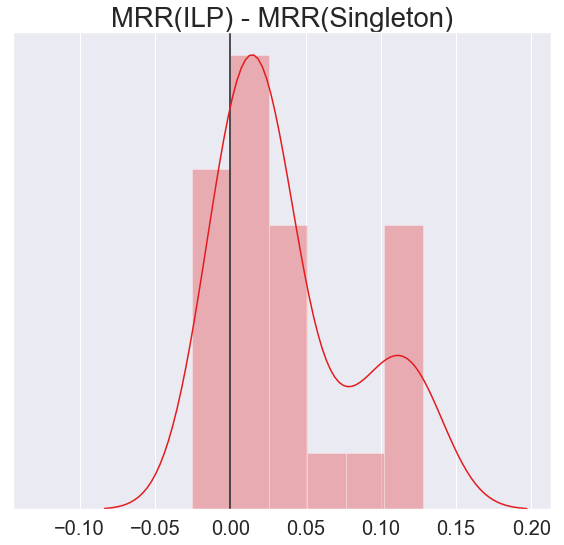

In [92]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
c=sns.color_palette('Set1', n_colors=3)

no_zeros = (mrrs[0] - mrrs[1])[(mrrs[0] - mrrs[1]) != 0]
bins1 = np.linspace(min([min(no_zeros), -max(no_zeros)]), 0, num=6)
bins2 = np.linspace(0, max([-min(no_zeros), max(no_zeros)]), num=6)

bins = np.concatenate((bins1, bins2))

ax.hist((mrrs[0] - mrrs[1])[(mrrs[0] - mrrs[1]) != 0], color=c[0], bins=bins, alpha=0.3)
ax_ = ax.twinx()
sns.kdeplot((mrrs[0] - mrrs[1])[(mrrs[0] - mrrs[1]) != 0], ax=ax_, c=c[0])
ax.axvline(x=0, c='k')
ax.set_title('MRR(ILP) - MRR(Singleton)', fontsize=27.5)
# fig.suptitle('MRR(IP) - MRR(ASE)', fontsize=27.5)

ax.tick_params(labelsize=20)

# ax.set_xticks([-0.002, 0 , 0.002])
ax.set_yticks([])
ax_.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('ip_minus_singleton_mbins_Ssize%i_acorn%i.pdf'%(S_size, acorn))

In [93]:
from scipy.stats import wilcoxon
T0, p0 = wilcoxon(mrrs[0], mrrs[1], alternative='greater')
p0

8.976614899965098e-05

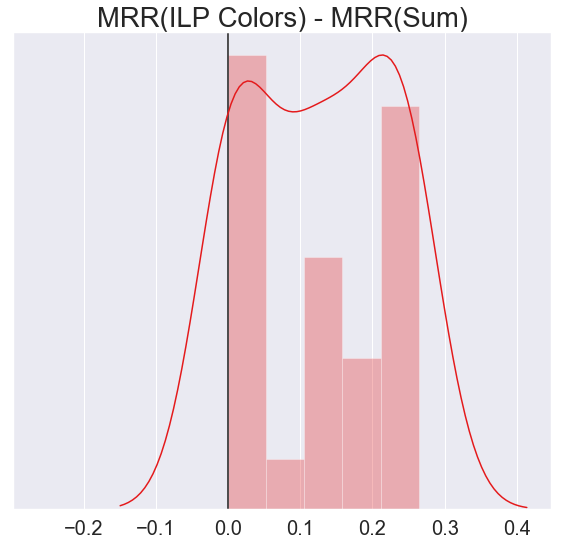

In [91]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
c=sns.color_palette('Set1', n_colors=3)

no_zeros = (mrrs[0] - mrrs[2])[(mrrs[0] - mrrs[2]) != 0]
bins1 = np.linspace(min([min(no_zeros), -max(no_zeros)]), 0, num=6)
bins2 = np.linspace(0, max([-min(no_zeros), max(no_zeros)]), num=6)

bins = np.concatenate((bins1, bins2))

ax.hist((mrrs[0] - mrrs[2])[(mrrs[0] - mrrs[2]) != 0], color=c[0], bins=bins, alpha=0.3)
ax_ = ax.twinx()
sns.kdeplot((mrrs[0] - mrrs[2])[(mrrs[0] - mrrs[2]) != 0], ax=ax_, c=c[0])
ax.axvline(x=0, c='k')
ax.set_title('MRR(ILP Colors) - MRR(Sum)', fontsize=27.5)
# fig.suptitle('MRR(IP) - MRR(ASE)', fontsize=27.5)

ax.tick_params(labelsize=20)

# ax.set_xticks([-0.002, 0 , 0.002])
ax.set_yticks([])
ax_.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('ip_minus_sum_mbins_Ssize%i_acorn%i.pdf'%(S_size, acorn))

In [94]:
from scipy.stats import wilcoxon
T1, p1 = wilcoxon(mrrs[0], mrrs[2], alternative='greater')
p1

4.149049653178655e-06